## Game plan:

DONE - 09/06/18
 - Retrieve user accounts created before 2017
 - Join the user account information with 2017 time series data
 - Filter the users by 26 answers that year
 - Apply the 4 month window to determine if the user is still active by the end of 2017
 - Drop the last 4 months' data
 - Train-test split 80:20
 - Build a baseline classification model
 
TO DO:
 - Build a pipeline (X as oversampler does not fit in pipeline)
 - Try different oversampling techniques (DONE-RandomOverSampler works the best)
 - Implement time series
 - User segmentation?
 - Implement voting classifier
 - Further tune classifiers (check hyper-parameter for xgboost)
 - Learning curve
 - Back-testing with 2018 data/cross-check if user came back in 2018

Story-telling:
 - Feature importance (Draw on map)
 - Cohort analysis

Extension:
 - Predict lifetime by posts in first month
 - Lifetime Customer Value
 - How to build an online model that automatically accumulate and produce the output
 - Build a flask app

In [19]:
import pickle
import patsy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.pipeline import Pipeline

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Clean data

In [3]:
with open('./data/processed/user_reputation.pkl', 'rb') as picklefile:
    user_reputation = pickle.load(picklefile)

In [4]:
user_reputation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8917507 entries, 0 to 8917506
Data columns (total 19 columns):
id                                int64
about_me_length                   int64
age                               object
creation_date                     datetime64[ns, UTC]
last_access_date                  datetime64[ns, UTC]
location                          object
reputation                        int64
up_votes                          int64
down_votes                        int64
profile_image_url                 object
website_url                       object
answer_reputation_total_2017      float64
question_reputation_total_2017    float64
accepted_reputation_total_2017    float64
answer_reputation_total_2018      float64
question_reputation_total_2018    float64
accepted_reputation_total_2018    float64
reputation_2017                   float64
reputation_2018                   float64
dtypes: datetime64[ns, UTC](2), float64(8), int64(5), object(4)
memory usage: 1

In [5]:
user_reputation['account_year'] = user_reputation.apply(lambda row:row[3].year, axis=1)
user_before_2017 = user_reputation[user_reputation['account_year']<2017]

KeyboardInterrupt: 

In [ ]:
with open('./data/processed/answer_time_series.pkl', 'rb') as picklefile:
    answer_time_series = pickle.load(picklefile)

In [ ]:
answer_time_series.head()

In [ ]:
user_before_2017_stats = pd.merge(user_reputation, answer_time_series, how = 'right', left_on='id', right_on='id')

In [ ]:
topans = user_before_2017_stats[user_before_2017_stats.values[:,-12:].sum(axis=1)>26]

In [ ]:
topans.head()

In [ ]:
topans['Active'] = topans.apply(lambda row:1 if row[-4:].sum()>0 else 0, axis=1)

In [ ]:
cols_to_drop = (['m_201709', 'm_201710', 'm_201711', 'm_201712', 'account_year', 'last_access_date', 'reputation',
                'answer_reputation_total_2017', 'question_reputation_total_2017', 'accepted_reputation_total_2017',
                'answer_reputation_total_2018', 'question_reputation_total_2018', 'accepted_reputation_total_2018', 
                 'reputation_2017', 'reputation_2018', 'age', 'profile_image_url'])
topans.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
topans.info()

In [ ]:
topans[['creation_year','creation_month']] = topans.apply(lambda row: pd.Series([row[2].year, row[2].month], index=['creation_year','creation_month']), axis=1)
topans.drop('profile_image_url', axis=1, inplace=True)

In [ ]:
topans.head()

In [ ]:
topans['location'] = topans.location.apply(lambda x:x.split(', ')[-1])

In [6]:
with open('./data/processed/topans.pkl','rb') as picklefile:
    topans = pickle.load(picklefile)

In [7]:
topans.head()

,id,about_me_length,location,up_votes,down_votes,website_url,m_201701,m_201702,m_201703,m_201704,m_201705,m_201706,m_201707,m_201708,Active,creation_year,creation_month
1274,6632595,0.0,,3.0,0.0,,0,0,1,0,13,3,1,0,1,2016,7
5951,5619724,217.0,Australia,87.0,3.0,,2,1,0,0,0,3,7,13,1,2015,11
5977,4315695,0.0,India,4.0,9.0,,0,0,0,0,0,0,0,0,1,2014,12
5979,8932080,354.0,France,61.0,10.0,https://www.awesomeprods.fr,0,0,0,0,0,0,0,0,1,2017,11
5993,1175029,334.0,,23.0,3.0,,11,7,7,1,5,3,5,5,1,2012,1


In [8]:
website_count = pd.DataFrame(topans.website_url.value_counts())
website_count.reset_index(inplace=True)
personal_website = set(website_count[website_count['website_url']==1]['index'].values)
topans['personal_website'] = topans['website_url'].apply(lambda x:1 if x in personal_website else 0)

In [9]:
topans.drop('website_url', axis=1, inplace=True)
topans.set_index('id', inplace=True)

## Formalize the X and Y's

In [10]:
y = topans['Active']
X = topans.drop('Active', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4444, stratify=y)

In [11]:
with open('./data/processed/location_dict.pkl', 'rb') as picklefile:
    location_dict = pickle.load(picklefile)

In [12]:
def map_dummify_Locations(df, location_dict):
    df['location'] = df.location.apply(lambda x:location_dict[x] if x in set(location_dict.keys()) else 'Others')
    location_dummy = patsy.dmatrix('location', data=df, return_type='dataframe')
    df = df.join(location_dummy)
    df.drop('location', axis=1, inplace=True)
    new_colnames = [item.replace('[','-') for item in list(df.columns)]
    new_colnames = [item.replace(']','') for item in new_colnames]
    df.columns = new_colnames
    return df

In [13]:
X_train = map_dummify_Locations(X_train, location_dict)
X_test = map_dummify_Locations(X_test, location_dict)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Perform some basic GridSearch

In [14]:
# Normalize the data
ssX = StandardScaler()
X_train_norm = ssX.fit_transform(X_train)

In [85]:
def gridSearchFiveModels(X, y):
    models = [
    #    ('knn', KNN),
    #    ('logistic', LogisticRegression),
    #    ('tree', DecisionTreeClassifier),
    #    ('forest', RandomForestClassifier),
        ('xgboost', XGBClassifier)
    ]

    param_choices = [
        {
            'max_depth': [3,4,5],
            'n_estimators': [1, 50, 100,200],
            'objective':['binary:logistic']
        }
    ]


    grids = {}
    for model_info, params in zip(models, param_choices):
        name, model = model_info
        grid = GridSearchCV(model(), params, scoring='accuracy', cv=5, n_jobs=-1)
        grid.fit(X, y)
        s = "{}: best score: {}".format(name, grid.best_score_)
        print(s)
        grids[name] = grid
    return grids

        """
        {
            'n_neighbors': range(2,12)
        },
        {
            'C': np.logspace(-3,6,12),
            'penalty':['l1', 'l2']
        },
        {
            'max_depth': [2,3,4,5],
            'min_samples_leaf': [3,6,10]
        },
        {
            'n_estimators': [50, 100, 200],
            'max_depth': [1,2,3,4,5],
            'min_samples_leaf': [3,6,10]
        },
        """
*Model performance*<br>
knn: best score: 0.8592953352104101<br>
logistic: best score: 0.8619587550414732<br>
tree: best score: 0.8675899855414352<br>
forest: best score: 0.8656875428049615<br>
xgboost: best score: 0.8759607335819192

In [15]:
with open('./data/model/answerer_prediction.pkl','rb') as picklefile:
    grids = pickle.load(picklefile)

## Check OverSampler

In [93]:
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=4444).fit_sample(X_train_norm, y_train)
grid_OverSampler = gridSearchFiveModels(X_train_resampled, y_train_resampled)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

xgboost: best score: 0.8941467290544716


grids['xgboost']
GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5], 'n_estimators': [1, 50, 100, 200], 'objective': ['binary:logistic']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [94]:
accuracy_score(y_train, grid_OverSampler['xgboost'].predict(X_train_norm))

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8917129594399209

In [92]:
confusion_matrix(y_train, xg.predict(X_train_norm))

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 1707,   107],
       [ 1316, 10011]])

## Check performance of SMOTE

In [81]:
X_train_resampled, y_train_resampled = SMOTE(random_state=444).fit_sample(X_train_norm, y_train) 

In [86]:
grid_SMOTE = gridSearchFiveModels(X_train_resampled, y_train_resampled)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

xgboost: best score: 0.8938377328507107


In [87]:
confusion_matrix(y_train, grid_SMOTE['xgboost'].predict(X_train_norm))

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 1098,   716],
       [  346, 10981]])

## Check Performance of ADASYN

In [89]:
X_train_resampled, y_train_resampled = ADASYN(random_state=444).fit_sample(X_train_norm, y_train) 

In [90]:
grid_ADASYN = gridSearchFiveModels(X_train_resampled, y_train_resampled)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

xgboost: best score: 0.8904878592114056


In [91]:
confusion_matrix(y_train, grid_ADASYN['xgboost'].predict(X_train_norm))

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 1086,   728],
       [  320, 11007]])

## Feature Importance

In [20]:
def plot_importance(model, df, title, columns=None):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:]
    plt.figure()
    plt.axvline(x=1/df.shape[1], color='#1DB954')
    plt.title(title, fontsize=35)
    plt.barh(range(10), importances[indices], color='#FF5A60', align='center', )
    if (columns == None):
        plt.yticks(range(10), df.columns[indices])
    else:
        plt.yticks(range(10), columns)
    plt.xlabel('Relative Importance', fontsize=25)
    return plt

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

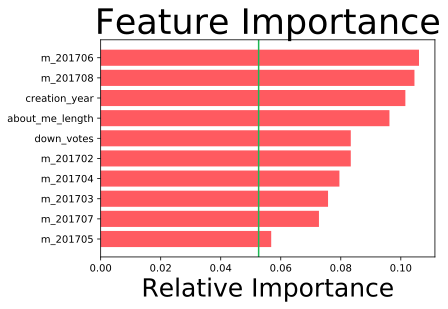

In [22]:
model = grids['xgboost'].best_estimator_
plot_importance(model, X_train, 'Feature Importance')